In [1]:
import os
import sys

# get source and data directories
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
data_dir = os.path.join(os.getcwd(), os.pardir, 'data/processed')

# set the source data directory as the current path
src_data_dir = os.path.join(src_dir, 'data')
sys.path.append(src_data_dir)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

//anaconda/envs/DAND/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
interest_file = os.path.join(data_dir, 'interest_data.csv')
additional_file = os.path.join(data_dir, 'additional_data.csv')
imdb_file = os.path.join(data_dir, 'imdb_data.csv')

In [4]:
interest_df = pd.read_csv(interest_file)
additional_df = pd.read_csv(additional_file)
imdb_df = pd.read_csv(imdb_file)

In [5]:
sorted_interest = interest_df.sort_values('interest')

In [6]:
mdf = pd.merge(imdb_df, interest_df, how='inner', on=['movie_title'])

In [7]:
# remove duplicates
mdf.duplicated().sum()
mdf = mdf.drop_duplicates()

In [8]:
mdf

,director_name,num_voted_users,duration,actor_3_facebook_likes,actor_2_name,cast_total_facebook_likes,gross,genres,actor_1_name,movie_title,...,movie_facebook_likes,num_user_for_reviews,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,actor_1_facebook_likes,interest
0,Christopher Nolan,1144337,164.0,23000.0,Christian Bale,106759,448130642.0,Action|Thriller,Tom Hardy,the dark knight rises,...,164000,2701.0,USA,PG-13,250000000.0,2012.0,23000.0,8.5,27000.0,9.22
1,Zack Snyder,371639,183.0,2000.0,Lauren Cohan,24450,330249062.0,Action|Adventure|Sci-Fi,Henry Cavill,batman v superman dawn of justice,...,197000,3018.0,USA,PG-13,250000000.0,2016.0,4000.0,6.9,15000.0,6.68
2,Zack Snyder,548573,143.0,748.0,Christopher Meloni,20495,291021565.0,Action|Adventure|Fantasy|Sci-Fi,Henry Cavill,man of steel,...,118000,2536.0,USA,PG-13,225000000.0,2013.0,3000.0,7.2,15000.0,3.01
3,Joss Whedon,995415,173.0,19000.0,Robert Downey Jr.,87697,623279547.0,Action|Adventure|Sci-Fi,Chris Hemsworth,the avengers,...,123000,1722.0,USA,PG-13,220000000.0,2012.0,21000.0,8.1,26000.0,10.12
4,Barry Sonnenfeld,268154,106.0,718.0,Michael Stuhlbarg,12572,179020854.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,Will Smith,men in black 3,...,40000,341.0,USA,PG-13,225000000.0,2012.0,816.0,6.8,10000.0,5.80
5,Marc Webb,451803,153.0,963.0,Andrew Garfield,28489,262030663.0,Action|Adventure|Fantasy,Emma Stone,the amazing spiderman,...,56000,1225.0,USA,PG-13,230000000.0,2012.0,10000.0,7.0,15000.0,3.61
6,Peter Jackson,483540,186.0,773.0,Adam Brown,9152,258355354.0,Adventure|Fantasy,Aidan Turner,the hobbit the desolation of smaug,...,83000,951.0,USA,PG-13,225000000.0,2013.0,972.0,7.9,5000.0,3.00
7,James Cameron,793059,194.0,794.0,Kate Winslet,45223,658672302.0,Drama|Romance,Leonardo DiCaprio,titanic,...,26000,2528.0,USA,PG-13,200000000.0,1997.0,14000.0,7.7,29000.0,0.84
8,Colin Trevorrow,418214,124.0,1000.0,Judy Greer,8458,652177271.0,Action|Adventure|Sci-Fi|Thriller,Bryce Dallas Howard,jurassic world,...,150000,1290.0,USA,PG-13,150000000.0,2015.0,2000.0,7.0,3000.0,6.23
9,Sam Mendes,522030,143.0,393.0,Helen McCrory,2039,304360277.0,Action|Adventure|Thriller,Albert Finney,skyfall,...,80000,1498.0,UK,PG-13,200000000.0,2012.0,563.0,7.8,883.0,6.45


In [10]:
mdf.describe()

,num_voted_users,duration,actor_3_facebook_likes,cast_total_facebook_likes,gross,num_critic_for_reviews,director_facebook_likes,facenumber_in_poster,movie_facebook_likes,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,actor_1_facebook_likes,interest
count,4.050000e+02,405.000000,404.000000,405.000000,3.650000e+02,404.000000,405.000000,401.000000,405.000000,405.000000,3.690000e+02,405.000000,404.000000,405.000000,405.000000,405.000000
mean,1.198120e+05,109.970370,1032.824257,13199.913580,6.918541e+07,251.193069,734.582716,1.573566,29174.212346,315.708642,4.923277e+07,2012.360494,2462.126238,6.520741,8552.676543,2.865160
std,1.711644e+05,20.854971,2652.758183,20057.780114,1.004151e+08,172.921739,3115.301606,2.253930,40032.211371,421.215913,5.864007e+07,6.851568,4598.249377,1.014335,15676.240955,4.016887
min,5.300000e+01,66.000000,0.000000,0.000000,1.620000e+02,2.000000,0.000000,0.000000,0.000000,1.000000,2.000000e+04,1939.000000,0.000000,3.100000,0.000000,0.050000
25%,2.103400e+04,97.000000,165.000000,1985.000000,9.203192e+06,121.000000,13.000000,0.000000,0.000000,85.000000,1.000000e+07,2012.000000,345.000000,5.900000,775.000000,0.770000
50%,5.553900e+04,105.000000,435.000000,5022.000000,3.450708e+07,222.500000,65.000000,1.000000,15000.000000,166.000000,2.600000e+07,2013.000000,720.500000,6.600000,2000.000000,1.650000
75%,1.369540e+05,120.000000,736.750000,19168.000000,8.364043e+07,351.750000,188.000000,2.000000,40000.000000,371.000000,6.000000e+07,2015.000000,1000.000000,7.200000,14000.000000,3.390000
max,1.251222e+06,240.000000,23000.000000,261818.000000,6.586723e+08,813.000000,23000.000000,19.000000,349000.000000,3018.000000,2.500000e+08,2016.000000,27000.000000,9.100000,260000.000000,36.000000


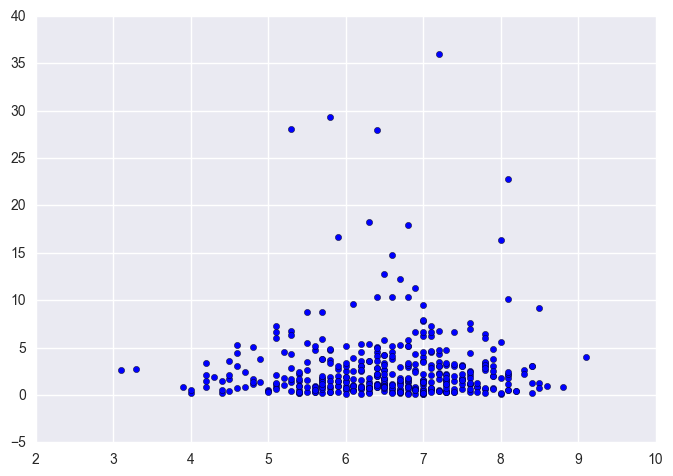

In [9]:
plt.scatter(mdf['imdb_score'], mdf['interest']) 
plt.show()